# Control hardware: system identification
**Characterizing quantum hardware with the BOULDER OPAL optimization engine**

The BOULDER OPAL optimization engine provides a large, modular collection of configuration options that allows it to be used for more applications than finding optimal and robust pulses. In this Application note, we show how the optimization engine can be used to determine the parameters that characterize some control hardware. We illustrate this with two examples: first by identifying a linear filter that is present in a single-qubit control line, and then by identifying a constant Hamiltonian to which a qubit is subject. The procedure consists of repeatedly measuring a qubit after applying a set of different pulses or after letting it evolve for different wait times. The results of these measurements are then given to the optimizer, which finds the parameters most likely to have generated those results.

## Imports and initialization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qctrlvisualizer import get_qctrl_style
from scipy.linalg import expm

from qctrl import Qctrl

plt.style.use(get_qctrl_style())

# Define standard matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=np.complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=np.complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=np.complex)

# Start a session with the API
qctrl = Qctrl()

## Characterizing the control lines

In this first section, we will consider the identification of a linear filter that alters the shape of the pulses in the control line. By feeding different control pulses and then measuring the qubit, we are able to extract information about the parameters that characterize the filter. This setup is illustrated in the figure below.

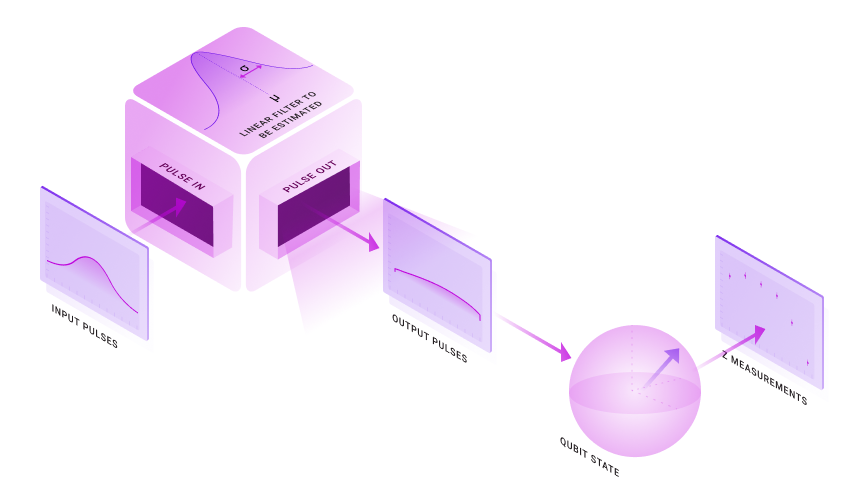

To exemplify this procedure, we will consider a one-qubit system obeying the following Hamiltonian:

$$ H(t) = \frac{1}{2} \mathcal{L} \left[ \alpha(t) \right] \sigma_x, $$

where $\alpha(t)$ is a real time-dependent control pulse and $\mathcal{L}$ is a filter applied to the pulse.
This linear filter acts on the control pulse $\alpha(t)$ according to the convolution product with some kernel $K(t)$:

$$ \mathcal{L} \left[ \alpha(t) \right] = \int_0^t \mathrm{d} s \; \alpha(s) K(t-s). $$

To characterize this filter, we want to determine the parameters that provide the form of the kernel $K(t)$.
We will consider a Gaussian kernel characterized by two unknown parameters, a standard deviation $\sigma$ and a mean $\mu$:

$$ K(t) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left\{ - \frac{(t-\mu)^2}{2\sigma^2} \right\}. $$

The standard deviation $\sigma$ roughly represents the range of frequencies that the filter allows to pass, while the mean $\mu$ represents a time offset between when the pulses were intended to be generated and when they are actually produced. To estimate these two parameters, we will simulate the effect of this filter on a series of pulses and then use the simulated results to find the most likely form of the filter's kernel.

### Simulating the input data

To estimate the parameters $\sigma$ and $\mu$, we subject our system to a series of Gaussian pulses with different standard deviations and timings, and measure their effect on the qubit. Each of these Gaussian wave packets will contain a different range of frequencies, and thus be differently affected by the linear filter. The different timings also result in a different effect of the pulses by the offset of the filter, as later pulses will have a larger portion of their area outside the time interval before the measurement. The values of the final measurements are then used to obtain an estimate of the parameters that characterize the filter.

As the Hamiltonian we are considering is proportional to $\sigma_x$, we will normalize all the Gaussian pulses to produce $\pi$ pulses, prepare the qubit initially in the state $|0 \rangle$, and measure the population in state $| 1 \rangle$. If no filter was present, the initial state would be flipped by the $\pi$ pulse and the population in state $|1 \rangle$ would be 1. Any deviations from this behavior represent the effect of the filter $\mathcal{L}$.

We will assume that the measurement results are given by some physical parameter (given in arbitrary units) linearly proportional to the population in the state $|1 \rangle$, but not necessarily the same, because the populations might not be directly accessible by the measurement apparatus. This results in two additional parameters that connect the measured results $M$ to the population $P_1$ of state $|1 \rangle$:

$$ M = a P_1 + b. $$

Together, $\sigma$, $\mu$, $a$, $b$ form the four variables that our optimization engine will attempt to determine.

In [2]:
# Define parameters to be estimated
actual_sigma = 300e-9  # s
actual_mu = 100e-9  # s
actual_a = 1.7
actual_b = -0.5

In [3]:
total_duration = 1000e-9  # s

# Define parameters of the Gaussian pulses to probe the filter
max_width = total_duration / 6.0
mean_values = np.linspace(max_width, total_duration - max_width, 6)
width_values = np.linspace(max_width / 8.0, max_width / 2.0, 4)

# Define sampled times
segments = 150
t_values = np.linspace(0.0, total_duration, segments + 1)

In [4]:
def population(pulse_widths, pulse_means, filter_sigma, filter_mu):
    """
    Calculates the transfer probability between states |0> and |1> for a
    batch of Gaussian pulses with given widths and means, while applying
    a Gaussian filter to the pulses with a given cutoff frequency and offset.
    """

    def gaussian_pulse(t, mean, width):
        return np.exp(-0.5 * ((t - mean) / width) ** 2.0) * np.sqrt(
            0.5 * np.pi / width ** 2.0
        )

    with qctrl.create_graph() as graph:
        alpha = qctrl.operations.pwc_signal(
            gaussian_pulse(
                t_values[None, None, :],
                pulse_means[None, :, None],
                pulse_widths[:, None, None],
            ),
            total_duration,
        )

        shift = qctrl.operations.stf_operator(
            signal=qctrl.operations.convolve_pwc(
                pwc=alpha,
                kernel_integral=qctrl.operations.gaussian_integral_function(
                    std=filter_sigma,
                    offset=filter_mu,
                ),
            ),
            operator=0.5 * sigma_x,
        )

        population = 1.0 - qctrl.operations.infidelity_stf(
            sample_times=t_values,
            hamiltonian=shift,
            target_operator=qctrl.operations.target(np.array([[0, 1], [0, 0]])),
        )
        population.name = "populations"

    graph_result = qctrl.functions.calculate_graph(
        graph=graph,
        output_node_names=["populations"],
    )
    return graph_result.output["populations"]["value"]

In [5]:
populations = population(
    pulse_widths=width_values,
    pulse_means=mean_values,
    filter_mu=actual_mu,
    filter_sigma=actual_sigma,
)

100%|██████████| 100/100 [00:05<00:00, 17.18it/s]


In [6]:
# Create measurement results with some uncertainty associated to them,
# we will estimate the standard deviation of this error as 1% of the population
population_errors = 0.01 * np.ones_like(populations)

measurement_results = (
    actual_a * np.random.normal(loc=populations, scale=population_errors) + actual_b
)

# Rescale error to arbitrary units
measurement_errors = np.abs(actual_a) * population_errors

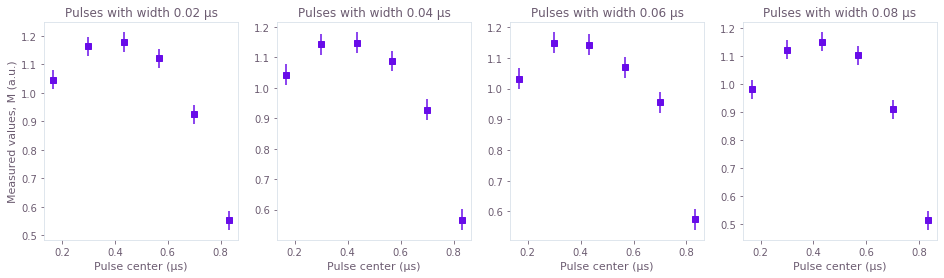

In [7]:
# Plot inputs
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].set_ylabel("Measured values, M (a.u.)")
for n in range(len(width_values)):
    axs[n].set_title(f"Pulses with width {width_values[n] * 1e6:.2f} µs")
    axs[n].set_xlabel("Pulse center (µs)")
    axs[n].errorbar(
        mean_values * 1e6,
        measurement_results[n],
        yerr=2.0 * measurement_errors[n],
        fmt="s",
    )

Each of these graphs represents the average measurement results of a series of simulated experiments where the offset of the Gaussian $\pi$ pulses vary. In each graph the width of the Gaussian control pulse is different, as indicated in their titles. The measured values $M$ plotted above are linearly proportional to the populations $P_1$:

$$ M = a P_1 + b. $$

The measured values are assumed to be subject to errors with Gaussian probability distributions that have a standard deviation that is 1% of $a$. This means that we are assuming that the error in the value of the of the population is of about 1%. The error bars in the graphs represent two times the standard deviation, having therefore a reliability of 95%.

### Estimating the parameters of the filter

The next step involves performing an optimization in which the four unknown parameters are estimated. This is done by the optimizer by trying to find the form of the evolution that would most closely match the measured points. Given a set of input points $M_i$ and the corresponding values $m_i$ that would be expected from a chosen set of the filter parameters $\sigma, \mu, a, b$, the cost function is:

$$ C = \sum_i \frac{[M_i-m_i(\sigma, \mu, a, b)]^2}{2(\Delta M_i)^2}, $$

where $\Delta M_i$ is the standard deviation of each of the measured input points $M_i$. Minimizing this cost function is equivalent to minimizing the negative log likelihood that a certain set of parameters $\sigma, \mu, a, b$ could generate the points $M_i$, for the case where the probability distribution of the errors is a Gaussian. In this case, the probability of a certain curve $m_i(\sigma, \mu, a, b)$ generating the points $M_i$ is the product of all the individual Gaussian probabilities:

$$ P = \prod_i \frac{1}{\sqrt{2\pi (\Delta M_i)^2}} \exp \left\{ - \frac{[M_i - m_i(\sigma, \mu, a, b)]^2}{2 (\Delta M_i)^2} \right\}. $$

It is easy to see that the negative logarithm of $P$ is the cost $C$ plus constants.

Minimizing this cost gives us the best choice of parameters that generated the original dynamics of the system, and also allows us to calculate the precision of the estimated parameters. This is done by using the Cramér–Rao bound to identify the Hessian of the cost function with the inverse of the covariance matrix for the variables estimated.

In [8]:
# Define Gaussian pulse, normalized to generate pi-pulses
def gauss_pulse(t, mean, width):
    return qctrl.operations.exp(
        -0.5 * ((t - mean) / width) ** 2.0
    ) * qctrl.operations.sqrt(0.5 * np.pi / width ** 2.0)


with qctrl.create_graph() as graph:

    # Parameters to estimate
    mu = qctrl.operations.bounded_optimization_variable(
        count=1, lower_bound=0.0, upper_bound=total_duration, name="mu"
    )
    sigma = qctrl.operations.bounded_optimization_variable(
        count=1, lower_bound=0.0, upper_bound=total_duration, name="sigma"
    )
    a = qctrl.operations.unbounded_optimization_variable(
        count=1, initial_lower_bound=-1.0, initial_upper_bound=1.0, name="a"
    )
    b = qctrl.operations.unbounded_optimization_variable(
        count=1, initial_lower_bound=-1.0, initial_upper_bound=1.0, name="b"
    )

    # Create Hamiltonian term
    # Create a 2D batch of signals with all values of mean and width you want to simulate.
    # This batch is preserved through the entire computation, which ends up being faster than
    # looping through all values.
    alpha = qctrl.operations.pwc_signal(
        values=gauss_pulse(
            t_values[None, None, :],
            mean_values[None, :, None],
            width_values[:, None, None],
        ),
        duration=total_duration,
        name="alpha",
    )

    gauss_filter = qctrl.operations.gaussian_integral_function(std=sigma, offset=mu)
    alpha_filtered = qctrl.operations.convolve_pwc(
        pwc=alpha, kernel_integral=gauss_filter
    )
    shift = qctrl.operations.stf_operator(signal=alpha_filtered, operator=0.5 * sigma_x)

    # Calculate |0> -> |1> transfer probability
    calculated_populations = 1.0 - qctrl.operations.infidelity_stf(
        sample_times=t_values,
        hamiltonian=shift,
        target_operator=qctrl.operations.target(operator=np.array([[0, 1], [0, 0]])),
        name="infidelities",
    )

    # Create measured points
    calculated_points = a * calculated_populations + b
    calculated_points.name = "calculated_points"

    # Calculate cost
    cost = qctrl.operations.sum(
        (calculated_points - measurement_results) ** 2.0
        / (2.0 * measurement_errors ** 2.0),
        name="cost",
    )

    # Calculate Hessian
    hessian = qctrl.operations.hessian_matrix(cost, [mu, sigma, a, b], name="hessian")

In [9]:
# Estimate the parameters
result = qctrl.functions.calculate_optimization(
    cost_node_name="cost",
    output_node_names=["mu", "sigma", "a", "b", "hessian"],
    optimization_count=10,
    graph=graph,
)

estimated_mu = result.output["mu"]["value"][0]
estimated_sigma = result.output["sigma"]["value"][0]
estimated_a = result.output["a"]["value"][0]
estimated_b = result.output["b"]["value"][0]

# Calculate 2-sigma uncertainties (error bars give 95% precision)
hessian = result.output["hessian"]["value"]
uncertainties = 2.0 * np.sqrt(np.diag(np.linalg.inv(hessian)))
uncertainty_mu, uncertainty_sigma, uncertainty_a, uncertainty_b = uncertainties

100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


In [10]:
mean_range = np.linspace(0.1 * total_duration, 0.9 * total_duration, 30)

calculated_curves = estimated_b + estimated_a * population(
    pulse_widths=width_values,
    pulse_means=mean_range,
    filter_mu=estimated_mu,
    filter_sigma=estimated_sigma,
)

ideal_curves = actual_b + actual_a * population(
    pulse_widths=width_values,
    pulse_means=mean_range,
    filter_mu=actual_mu,
    filter_sigma=actual_sigma,
)

100%|██████████| 100/100 [00:02<00:00, 33.65it/s]



actual sigma = 0.3 µs
estimated sigma = (0.298 ± 0.027) µs

actual mu = 0.1 µs
estimated mu = (0.098 ± 0.008) µs

actual a = 1.7 au
estimated a = (1.777 ± 0.101) au

actual b = -0.5 au
estimated b = (-0.572 ± 0.100) au


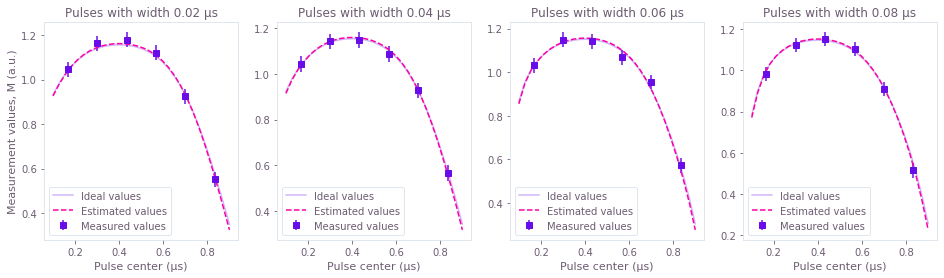

In [11]:
# Print parameter estimates
print(f"\nactual sigma = {actual_sigma/1e-6} µs")
print(
    f"estimated sigma = ({estimated_sigma/1e-6:.3f} ± {uncertainty_sigma/1e-6:.3f}) µs"
)

print(f"\nactual mu = {actual_mu/1e-6} µs")
print(f"estimated mu = ({estimated_mu/1e-6:.3f} ± {uncertainty_mu/1e-6:.3f}) µs")

print(f"\nactual a = {actual_a} au")
print(f"estimated a = ({estimated_a:.3f} ± {uncertainty_a:.3f}) au")

print(f"\nactual b =", actual_b, "au")
print(f"estimated b = ({estimated_b:.3f} ± {uncertainty_b:.3f}) au")

# Plot results
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].set_ylabel("Measurement values, M (a.u.)")

for n in range(len(width_values)):
    axs[n].set_title(f"Pulses with width {width_values[n] * 1e6:.2f} µs")
    axs[n].set_xlabel("Pulse center (µs)")
    axs[n].errorbar(
        mean_values * 1e6,
        measurement_results[n],
        yerr=2.0 * measurement_errors[n],
        fmt="s",
        color="C0",
        label="Measured values",
    )
    axs[n].plot(
        mean_range * 1e6, ideal_curves[n], color="C0", label="Ideal values", alpha=0.3
    )
    axs[n].plot(
        mean_range * 1e6,
        calculated_curves[n],
        "--",
        label="Estimated values",
        color="C1",
    )
    axs[n].legend(loc=3)

In the graphs above, we can compare the curves that represent the values that would be measured if the system followed the estimated filter (dashed), and the values that would be measured if perfect measurements were performed on a system subject to the real filter (solid). Each graph corresponds to sets of experiments where pulses of the same width are applied at different points in time, as indicated in their titles and $x$ axis. The close match between the two curves highlights the fact that the estimated parameters are close to the real values.

Above we also provide explicit estimates of the parameters $\sigma$ (`sigma`) and $\mu$ (`mu`) of the Gaussian kernel of the linear filter:

$$ K(t) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left\{ - \frac{(t-\mu)^2}{2\sigma^2} \right\}. $$

The other two parameters `a` and `b` represent the relationship between the values actually measured $M$ and the populations $P_1$:

$$ M = a P_1 + b. $$

The errors estimated for the variables above have a certainty of 2 times the standard deviation, or 95%.

## Identifying constant terms of a single-qubit Hamiltonian

The optimizer also allows a user to characterize terms of a Hamiltonian to which their qubits are exposed. In this section, we will consider how to estimate a constant Hamiltonian that rotates a single qubit. In this case, preparing different initial states and letting the qubit evolve for different times before measuring it will reveal information about the parameters of the qubit rotation. This setup is illustrated below.

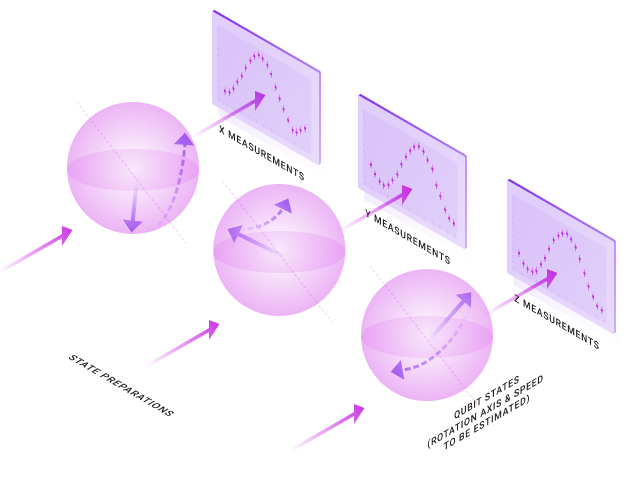

In more detail, if we exclude terms proportional to the identity (which affect all states in the same way and therefore are irrelevant to the qubit's evolution), a constant single-qubit Hamiltonian can be written in terms of the Pauli matrices:

$$ H = \frac{1}{2} \left( \Omega_x \sigma_x + \Omega_y \sigma_y + \Omega_z \sigma_z \right). $$

The task of the optimizer in this case will be to determine these three parameters $\Omega_x$, $\Omega_y$, and $\Omega_z$. This can be done by preparing the system in different initial states, and then letting it evolve for different wait times, before measuring it. The sets of measured points are then provided to the optimization engine, which finds the parameters most likely to have generated that series of points.

### Simulating the input data

The experiments used here to determine a constant term in the Hamiltonian consist of simply letting a qubit evolve for different initial states, during different wait periods. We prepare these qubits in the eigenstates of $\sigma_z$, $\sigma_x$, and $\sigma_y$, and then measure the populations in eigenstates of $\sigma_y$, $\sigma_z$, and $\sigma_x$, respectively. Information about the evolution of these three initial states is sufficient to characterize the three parameters that form the Hamiltonian. Moreover, measuring populations that are not in the same eigenbasis as the initial states allows us to get information about the direction of the rotation of the qubit, depending on whether the population initially increases or decreases.

In [12]:
# Define parameters to be estimated
actual_Omega_x = (2.0 * np.pi) * 0.5e6  # Hz
actual_Omega_y = (2.0 * np.pi) * 1.5e6  # Hz
actual_Omega_z = (2.0 * np.pi) * 1.8e6  # Hz

actual_Omegas = [actual_Omega_x, actual_Omega_y, actual_Omega_z]

In [13]:
# range of wait times in the different experiments
wait_times = np.linspace(25e-9, 500e-9, 20)

# list of initial states
initial_states = np.array(
    [
        [[1.0 + 0.0j], [0.0 + 0.0j]],
        [[1.0 + 0.0j], [1.0 + 0.0j]] / np.sqrt(2.0),
        [[1.0 + 0.0j], [0.0 + 1.0j]] / np.sqrt(2.0),
    ]
)
initial_state_names = [
    r"$\vert 0 \rangle$",
    r"$(\vert 0 \rangle + \vert 1 \rangle)/\sqrt{2}$",
    r"$(\vert 0 \rangle +i \vert 1 \rangle)/\sqrt{2}$",
]

# list of states whose population will be measured at the end
projector_states = np.array(
    [
        [[1.0 + 0.0j], [0.0 + 1.0j]] / np.sqrt(2.0),
        [[1.0 + 0.0j], [0.0 + 0.0j]],
        [[1.0 + 0.0j], [1.0 + 0.0j]] / np.sqrt(2.0),
    ]
)
projector_state_names = [
    r"$(\vert 0 \rangle +i \vert 1 \rangle)/\sqrt{2}$",
    r"$\vert 0 \rangle$",
    r"$(\vert 0 \rangle + \vert 1 \rangle)/\sqrt{2}$",
]

In [14]:
# define Hamiltonian
Hamiltonian = lambda Omegas: 0.5 * (
    Omegas[0] * sigma_x + Omegas[1] * sigma_y + Omegas[2] * sigma_z
)

# define unitaries for Hamiltonian
Ut = lambda t, Omegas: expm(-1.0j * t * Hamiltonian(Omegas))

# define function to calculate the populations given Omegas and wait times
# this function first calculates the unitaries for all wait times and then
# calculates the projected populations for different initial states and projectors.
# the return value is thefore in the shape of [len(projector_states), len(wait_times)]
def get_populations(Omegas, wait_times):
    unitaries = np.array([Ut(t, Omegas) for t in wait_times])
    return np.array(
        [
            np.abs(
                np.matmul(
                    projector_state.conj().T, np.matmul(unitaries, initial_state)
                ).flatten()
            )
            ** 2
            for projector_state, initial_state in zip(projector_states, initial_states)
        ]
    )

In [15]:
# calculate expected values
expectation_values = get_populations(actual_Omegas, wait_times)

# actual measurement results will have a certain uncertainty to them
# we will estimate the standard deviation of this error at 0.01
measurement_errors = 0.01 * np.ones_like(expectation_values)
measurement_results = np.random.normal(loc=expectation_values, scale=measurement_errors)

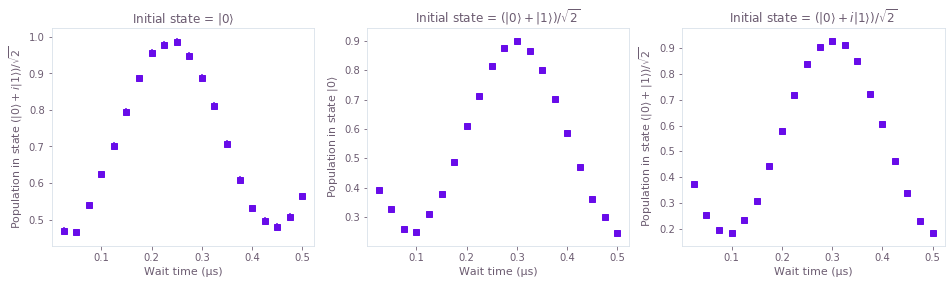

In [16]:
# plot inputs
measurement_times = wait_times * 1e6

fig, axs = plt.subplots(1, len(projector_states), figsize=(16, 4))
for n in range(len(projector_states)):
    axs[n].set_title("Initial state = " + initial_state_names[n])
    axs[n].set_ylabel("Population in state " + projector_state_names[n])
    axs[n].set_xlabel("Wait time (µs)")
    axs[n].errorbar(
        measurement_times,
        measurement_results[n],
        yerr=measurement_errors[n],
        fmt="s",
        color="C0",
    )

The graphs above show the values of the measurement results, considering an error whose standard deviation is 1% of the population. Each graph represent a set of experiments with the same initial state (given in the title) and same measured population (given in the $y$ axis). The error bars in the graphs have a length of $2\sigma$, or 95% reliability.

### Estimating the parameters of the Hamiltonian

The parameter estimation for the Hamiltonian terms is then performed by finding the form of the evolution that most closely matches the measured points. Given a set of input points $P_i$ and the corresponding populations $p_i$ that would be expected for a given set of Hamiltonian parameters $\Omega_x$, $\Omega_y$, and $\Omega_z$, the cost function is:

$$ C = \sum_i \frac{[P_i-p_i(\Omega_x, \Omega_y, \Omega_z)]^2}{2(\Delta P_i)^2}, $$

where $\Delta P_i$ is the standard deviation of each of the measured points $P_i$. Minimizing this cost function is equivalent to minimizing the negative log likelihood that a certain set of parameters $\Omega_x, \Omega_y, \Omega_z$ could generate the points $P_i$, for the case where the probability distribution of the errors is a Gaussian. In this case, the probability of a certain curve $p_i(\Omega_x, \Omega_y, \Omega_z)$ generating the points $P_i$ is the product of all the individual Gaussian probabilities:

$$ P = \prod_i \frac{1}{\sqrt{2\pi (\Delta P_i)^2}} \exp \left\{ - \frac{[P_i - p_i(\Omega_x, \Omega_y, \Omega_z)]^2}{2 (\Delta P_i)^2} \right\}. $$

It is easy to see that the negative logarithm of $P$ is the cost $C$ plus constants.

Minimizing the cost gives us the best choice of parameters that generate the original dynamics of the system, and also allows us to calculate the precision of the estimated parameters. This is done by using the Cramér-Rao bound to identify the Hessian of the cost function with the inverse of the covariance matrix for the variables estimated.

In [17]:
with qctrl.create_graph() as graph:
    # forbids frequencies whose half-periods are shorter than the smaller spacing between points
    min_time_resolution = np.min(np.abs(np.diff(np.unique(np.pad(wait_times, (1, 0))))))

    # Parameters to be estimated
    Omegas = [
        qctrl.operations.bounded_optimization_variable(
            1,
            lower_bound=-1.0 / min_time_resolution,
            upper_bound=1.0 / min_time_resolution,
            name=name,
        )
        for name in ["omega_x", "omega_y", "omega_z"]
    ]

    # Create coefficients of the Hamiltonian
    # to calculate the infidelities at the intermediate times, you can create a batch of Hamiltonian
    # coefficients with the duration set to 1 and signal value set to be scaled by the intermediate times
    signals = [
        qctrl.operations.pwc_signal(duration=1, values=omega * wait_times[:, None])
        for omega in Omegas
    ]

    hamiltonian = qctrl.operations.pwc_sum(
        [
            qctrl.operations.pwc_operator(signal=signal, operator=operator)
            for signal, operator in zip(
                signals, [sigma_x / 2, sigma_y / 2, sigma_z / 2]
            )
        ]
    )

    # Calculate the projected populations
    populations = [
        1
        - qctrl.operations.infidelity_pwc(
            hamiltonian=hamiltonian,
            target_operator=qctrl.operations.target(
                operator=projector_state @ initial_state.T.conj()
            ),
        )
        for projector_state, initial_state in zip(projector_states, initial_states)
    ]

    # Calculate cost
    cost = qctrl.operations.sum(
        [
            qctrl.operations.sum(
                (population - measurement_result) ** 2.0
                / (2.0 * measurement_error ** 2.0)
            )
            for measurement_result, measurement_error, population in zip(
                measurement_results, measurement_errors, populations
            )
        ],
        name="cost",
    )

    # Calculate Hessian
    hessian = qctrl.operations.hessian_matrix(cost, Omegas, name="hessian")

In [18]:
# Estimate the parameters
result = qctrl.functions.calculate_optimization(
    cost_node_name="cost",
    output_node_names=["omega_x", "omega_y", "omega_z", "hessian"],
    graph=graph,
)

estimated_Omegas = [
    result.output["omega_x"]["value"][0],
    result.output["omega_y"]["value"][0],
    result.output["omega_z"]["value"][0],
]

# Calculate 2-sigma uncertainties (error bars give 95% precision)
hessian = result.output["hessian"]["value"]
uncertainties = 2.0 * np.sqrt(np.diag(np.linalg.inv(hessian)))
Omega_x_uncertainty, Omega_y_uncertainty, Omega_z_uncertainty = uncertainties

100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


In [19]:
# Now we verify the estimation results using a different set of wait times
wait_times_verification = np.linspace(1e-9, 500e-9, 100)

# calculate expected values for verification
expectation_values_verification = get_populations(
    actual_Omegas, wait_times_verification
)

# calculate estimated values for verification
estimated_values_verification = get_populations(
    estimated_Omegas, wait_times_verification
)

real Omega_x = 3.1415926535897927 MHz
estimated Omega_x = ( 3.078 ± 0.103 ) MHz
real Omega_y = 9.42477796076938 MHz
estimated Omega_y = ( 9.42 ± 0.135 ) MHz
real Omega_z = 11.309733552923253 MHz
estimated Omega_z = ( 11.295 ± 0.117 ) MHz


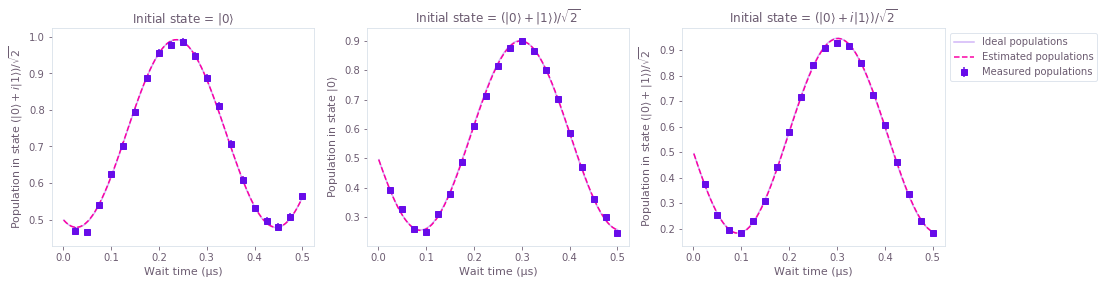

In [20]:
# Plot results
measurement_times_verification = wait_times_verification / 1e-6

fig, axs = plt.subplots(1, len(projector_states), figsize=(16, 4))
for n in range(len(projector_states)):
    axs[n].set_title("Initial state = " + initial_state_names[n])
    axs[n].set_ylabel("Population in state " + projector_state_names[n])
    axs[n].set_xlabel("Wait time (µs)")
    axs[n].errorbar(
        measurement_times,
        measurement_results[n],
        yerr=measurement_errors[n],
        fmt="s",
        label="Measured populations",
        color="C0",
    )
    axs[n].plot(
        measurement_times_verification,
        expectation_values_verification[n],
        color="C0",
        label="Ideal populations",
        alpha=0.3,
    )
    axs[n].plot(
        measurement_times_verification,
        estimated_values_verification[n],
        "--",
        label="Estimated populations",
        color="C1",
    )
axs[-1].legend(loc=2, bbox_to_anchor=(1, 1))

# print parameter estimates
print("real Omega_x =", actual_Omegas[0] * 1e-6, "MHz")
print(
    "estimated Omega_x = (",
    np.around(estimated_Omegas[0] * 1e-6, 3),
    "±",
    np.around(Omega_x_uncertainty * 1e-6, 3),
    ") MHz",
)

print("real Omega_y =", actual_Omegas[1] * 1e-6, "MHz")
print(
    "estimated Omega_y = (",
    np.around(estimated_Omegas[1] * 1e-6, 3),
    "±",
    np.around(Omega_y_uncertainty * 1e-6, 3),
    ") MHz",
)

print("real Omega_z =", actual_Omegas[2] * 1e-6, "MHz")
print(
    "estimated Omega_z = (",
    np.around(estimated_Omegas[2] * 1e-6, 3),
    "±",
    np.around(Omega_z_uncertainty * 1e-6, 3),
    ") MHz",
)

The three parameters estimated above, $\Omega_x$ (`Omega_x`), $\Omega_y$ (`Omega_y`), and $\Omega_z$ (`Omega_z`) correspond to the three coefficients present in the single-qubit Hamiltonian given in the beginning of this section:

$$ H = \frac{1}{2} \left( \Omega_x \sigma_x + \Omega_y \sigma_y + \Omega_z \sigma_z \right). $$

The errors in the parameter estimates correspond to 2 times the standard deviation and thus have 95% reliability.

In the graphs above, we can compare the curves that represent the populations that would be measured if the system followed the estimated Hamiltonian (dashed), and the populations that would be measured if perfect measurements were performed on the real Hamiltonian (solid). Each graph corresponds to sets of experiments with a given initial state and final measurement, as indicated in the title and $y$ label of each of them. The close match between the two curves highlights the fact that the estimated parameters are close to the real values.